In [8]:
import flopy
import numpy as np
import matplotlib.pyplot as plt

In [9]:

# Define model workspace
model_ws = "./modflow_model_2"

# Create a MODFLOW model instance
model = flopy.seawat.Seawat(modelname="example_model", model_ws=model_ws, exe_name="mf2005")


# Define model dimensions
nlay = 50
nrow = 190
ncol = 220
delr = 12.0  # Cell width along rows (extend 2200 / 220)
delc = 12.0  # Cell width along columns (extend 1900 / 190)

# Define top elevation
top_elev = 190.0

# Define layer thickness (uniform thickness)
layer_thickness = 25.0 / nlay

perlen = 30
nper = 5
nstp = np.repeat(1,nper)
steady = np.append(np.array([True]),np.repeat(False,nper-1))

# Create DIS package
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc,top=top_elev, 
                               botm=[top_elev - (i * layer_thickness) for i in range(1, nlay + 1)],
                               nper = nper,
                               perlen = perlen,
                               nstp = nstp,
                               steady = steady)



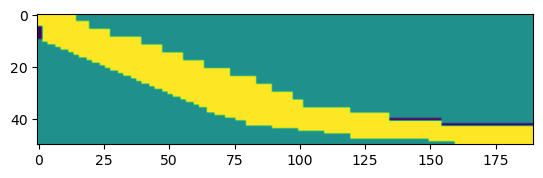

In [10]:



# Define ibound and initial conditions
ibound = np.ones((nlay, nrow, ncol), dtype=int)

# Set constant head boundary conditions for the first and last rows




# Change the values in the top left corner to 1s
ibound[:3, 15:,:] = 0
ibound[3:6, 20:,:] = 0
ibound[6:9, 28:,:] = 0
ibound[9:12, 40:,:] = 0
ibound[12:15, 48:,:] = 0
ibound[15:18, 56:,:] = 0
ibound[18:21, 64:,:] = 0
ibound[21:24, 74:,:] = 0
ibound[24:27, 84:,:] = 0
ibound[27:30, 90:,:] = 0
ibound[30:33, 98:,:] = 0
ibound[33:36, 102:,:] = 0
ibound[36:38, 120:,:] = 0
ibound[38:40, 135:,:] = 0
ibound[40:42, 155:,:] = 0

ibound[40, 135:155,:] = -1
ibound[42, 155:,:] = -1





rows  = ([160]+[150] + [120]  + 
         list(np.linspace(120,80,5).astype(int)) + 
         list(np.linspace(80,65,5).astype(int)) + 
         list(np.linspace(65,0,28).astype(int)))
for layer in range(40):
    row = rows[layer]
    ibound[49-layer,:row,:]= 0


#ibound[45:-1, 180:,:] = 0



ibound[5:10, 0:2, :] = -1  # Constant head for the first row
#ibound[:, -1, :] = -1  # Constant head for the last row


plt.imshow(ibound[:,:,2])



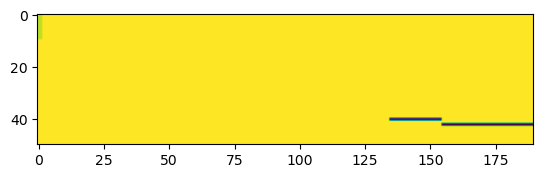

In [11]:
# Define initial head conditions
initial_head = np.full((nlay, nrow, ncol),190, dtype=float)
initial_head[:10, 0:2, :] = 188  # Initial head for the first row
#initial_head[:, -1, :] = 178.0  # Initial head for the last row
initial_head[40, 135:155,:] = 170
initial_head[42, 155:,:] = 170

plt.imshow(initial_head[:,:,3])
#plt.colorbar()

In [12]:

# Create BAS package
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=initial_head)

# Define hydraulic properties
horizontal_k = 6.9  # Horizontal hydraulic conductivity (m/day)
vertical_k = 0.1   # Vertical hydraulic conductivity (m/day)
porosity = 0.25     # Porosity

# Create LPF package (Layer Property Flow package)
lpf = flopy.modflow.ModflowLpf(model, hk=horizontal_k, vka=vertical_k, laytyp=1, ipakcb=53,ss=0.0002,sy=0.33)



pcg = flopy.modflow.ModflowPcg(model, hclose=1e-3)


# Create a steady-state MODFLOW model
# You can add additional packages and settings as needed for your specific problem


# OC - Output Control Option
oc = flopy.modflow.ModflowOc(
    model,
    stress_period_data= None,
    compact=True,
)

# Write MODFLOW input files
model.write_input()

In [13]:


# Run the MODFLOW model
model.run_model()


FloPy is using the following executable to run the model: /Users/shuyangwang/.local/share/flopy/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: example_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/09/07  3:17:39

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/09/07  3:17:53
 Elapsed run time: 14.456 Seconds

  Normal termination of simulation


(True, [])

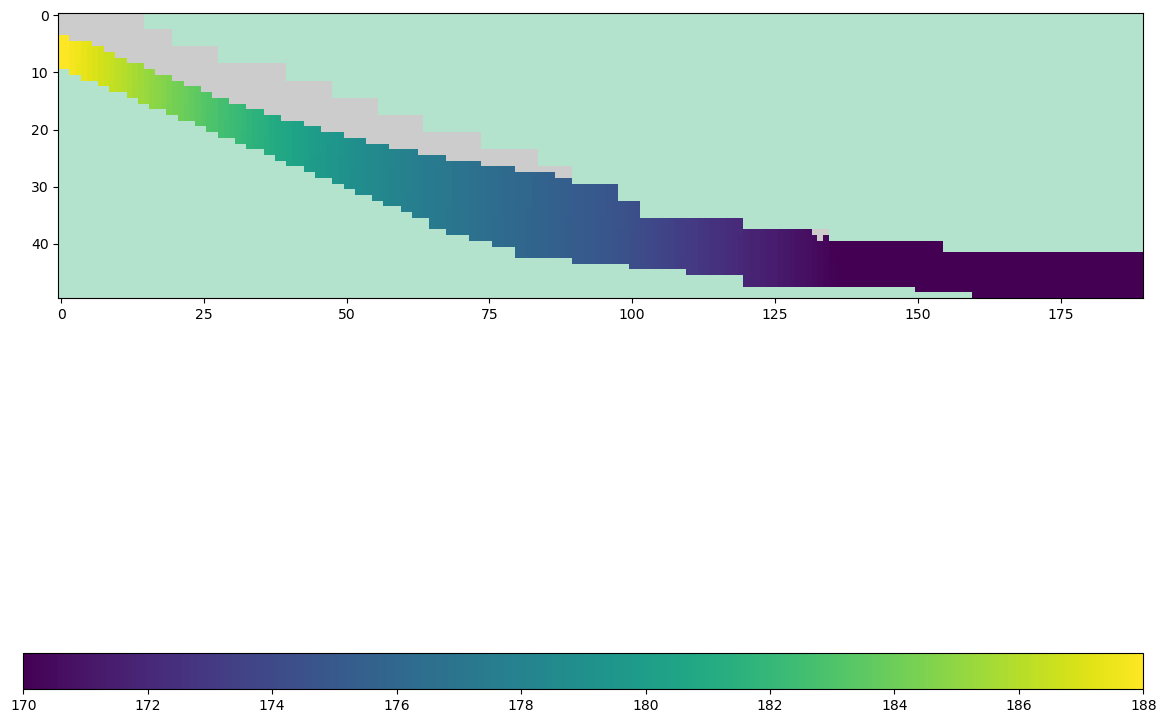

In [16]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

budobj = bf.HeadFile(model_ws + '/example_model.hds')
times = budobj.get_times()
head = budobj.get_data(totim=times[-1])
# Assuming 'head', 'ibound' are defined somewhere in your code

arr = head[:, :, 10].copy()
arr[arr < 0] = np.nan

topo = ibound[:, :, 0].copy()
topo[topo == -1] = 1



# Create a 2x1 grid of subplots
fig,ax1 = plt.subplots(figsize=(14,12))
#fig.figure()

# Plot 'topo' in the first subplot
ax1.imshow(topo, cmap='Pastel2')

# Plot 'arr' in the second subplot
im = ax1.imshow(arr)

# Create a colorbar at the bottom
cax = fig.add_axes([0.1, 0.05, 0.8, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')

# Show the plots
plt.show()

In [17]:
itype = flopy.mt3d.Mt3dSsm.itype_dict()
itype

{'CHD': 1,
 'BAS6': 1,
 'PBC': 1,
 'WEL': 2,
 'DRN': 3,
 'RIV': 4,
 'GHB': 5,
 'MAS': 15,
 'CC': -1}

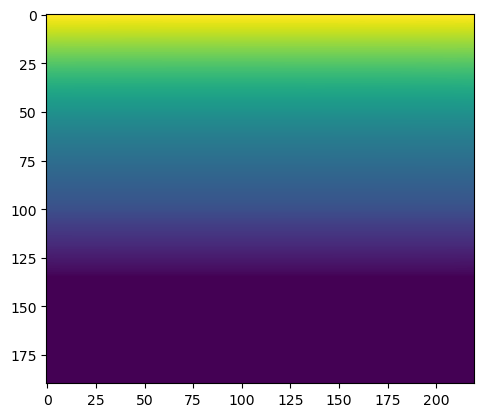

In [18]:
budobj = bf.HeadFile(model_ws + '/example_model.hds')
times = budobj.get_times()
head = budobj.get_data(totim=times[-1])
head[head<0]=np.nan


topview = head[0].copy()
for n in range(head.shape[0]):
    #print(n)
    layer = head[n]
    topview[np.isnan(topview)] = layer[np.isnan(topview)]


plt.imshow(topview)